In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
path = "/content/drive/Shareddrives/CIS 520/final project/hotel_bookings_processed.csv"
data = pd.read_csv(path)
data

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BGR,country_BHR,country_BHS,...,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,distribution_channel_Corporate,distribution_channel_Direct,distribution_channel_TA/TO,distribution_channel_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,assigned_room_type_A,assigned_room_type_B,assigned_room_type_C,assigned_room_type_D,assigned_room_type_E,assigned_room_type_F,assigned_room_type_G,assigned_room_type_H,assigned_room_type_I,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,day_of_week,day_of_year,is_family,customer_number,night_number
0,0,342,2015,7,27,1,0,0,2,0.0,0,0,0,0,3,0.0,0.0,0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,182,0,2.0,0
1,0,737,2015,7,27,1,0,0,2,0.0,0,0,0,0,4,0.0,0.0,0,0.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2,182,0,2.0,0
2,0,7,2015,7,27,1,0,1,1,0.0,0,0,0,0,0,0.0,0.0,0,75.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3,183,0,1.0,1
3,0,13,2015,7,27,1,0,1,1,0.0,0,0,0,0,0,304.0,0.0,0,75.00,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,3,183,0,1.0,1
4,0,14,2015,7,27,1,0,2,2,0.0,0,0,0,0,0,240.0,0.0,0,98.00,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,4,184,0,2.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40055,0,212,2017,8,35,31,2,8,2,1.0,0,0,0,0,1,143.0,0.0,0,89.75,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,6,253,1,3.0,10
40056,0,169,2017,8,35,30,2,9,2,0.0,0,0,0,0,0,250.0,0.0,0,202.27,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,6,253,0,2.0,11
40057,0,204,2017,8,35,29,4,10,2,0.0,0,0,0,0,0,250.0,0.0,0,153.57,0,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,255,0,2.0,14
40058,0,211,2017,8,35,31,4,10,2,0.0,0,0,0,0,0,40.0,0.0,0,112.80,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,3,257,0,2.0,14


In [5]:
## Initialize X, y and split dataset
df = data.copy()
y = df['is_canceled']
X = df.drop(['is_canceled'], axis=1)
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.20, random_state=42)
## Rebalance
X_train_balanced, y_train_balanced = SMOTE().fit_sample(X_train, y_train)

# Ensemble by Soft Voting

Selected the most accurate sklearn models (see notebooks "Basic Models Experiment") to combine as a new multi-classifier voting estimator.

In [ ]:
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [6]:
def softvote(X_train, X_test, y_train, y_test):

    clf1 = DecisionTreeClassifier(max_depth=12)
    # clf1 = XGBClassifier()
    clf2 = MLPClassifier(alpha=0.001, hidden_layer_sizes=(100,100),
                        solver='adam', activation='logistic')
    clf3 = RandomForestClassifier(max_features='sqrt',
                                  min_samples_split=2,
                                  n_estimators=500)
    eclf = VotingClassifier(estimators=[('DT', clf1), ('NN', clf2), ('RF', clf3)],
                            voting='soft', weights=[1, 2, 2])
    
    clf1 = clf1.fit(X_train, y_train) 
    clf2 = clf2.fit(X_train, y_train)
    clf3 = clf3.fit(X_train, y_train)
    eclf = eclf.fit(X_train, y_train)
    y_pred = eclf.predict(X_test)
    accu = round(accuracy_score(y_test, y_pred), 4)
    
    return accu

In [8]:
accu = softvote(X_train, X_test, y_train, y_test)
print(accu)

0.9752

# DeepFM (Feature Subset)

In [ ]:
!pip install torchfm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchfm.layer import FactorizationMachine, FeaturesEmbedding, FeaturesLinear, MultiLayerPerceptron
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [ ]:
class DeepFM(nn.Module):
    def __init__(self, field_dims, embed_dim, mlp_dims, dropout, num_classes):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout, output_layer=False)
        self.last_linear = nn.Linear(mlp_dims[-1], num_classes)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        embed_x = self.embedding(x)
        x = torch.relu(self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim)))
        x = self.last_linear(x)
        return x

In [ ]:
field_dims = [1, 4, 2, 3, 1, 1, 2, 2, 1, 1, 1, 1, 5, 126, 6, 4, 10, 11, 3, 4, 2, 1, 1, 1]
assert sum(np.array(field_dims)) == X_train.shape[1]
model = DeepFM(field_dims, 4, [32, 32, 32], 0.3, 4)
model = model.to("cuda:0")
epochs = 100
lr = 5e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
weight = compute_class_weight(class_weight="balanced", classes=np.array([0, 1, 2, 3]), y=np.squeeze(y_train))

loss = nn.CrossEntropyLoss(weight=torch.tensor(weight).to("cuda:0").float())
batch_size =1024
valid_interval = 1
train_loss = []
f1 = []
max_f1 = -1
max_pred = None

In [ ]:
for epoch in range(epochs):
    X_train, y_train = shuffle(X_train, y_train)
    model.train()
    tmp_loss = []
    for index in range(0, X_train.shape[0], batch_size):
        X = X_train[index:index + batch_size]
        y = y_train[index:index + batch_size]
        X = torch.tensor(X).to("cuda:0")
        y = torch.squeeze(torch.tensor(y).to("cuda:0"))
        pred = model(X)
        loss_v = loss(pred, y)
        loss_v.backward()
        optimizer.step()
        model.zero_grad()
        tmp_loss.append(loss_v.item())
    print("epoch %d: train loss %.2f" % (epoch + 1, np.mean(tmp_loss)))
    train_loss.append(np.mean(tmp_loss))
    tmp_loss = []
    if (epoch + 1) % valid_interval == 0:
            preds = []
            model.eval()
            with torch.no_grad():
                for index in range(0, X_test.shape[0], batch_size):
                    X = X_test[index:index + batch_size]
                    y = y_test[index:index + batch_size]
                    X = torch.tensor(X).to("cuda:0")
                    y = torch.squeeze(torch.tensor(y).to("cuda:0"))
                    pred = model(X)
                    loss_v = loss(pred, y)
                    tmp_loss.append(loss_v.item())
                    pred = torch.argmax(pred, 1)
                    preds.extend(pred.cpu().numpy().tolist())
                tmp_f1 =  f1_score(y_test, preds,average='weighted')
                f1.append(tmp_f1)
                if max_f1 < tmp_f1:
                    max_f1 = tmp_f1
                    max_pred = preds
                print("epoch %d: f1 %.2f" % (epoch + 1, tmp_f1))

epoch 1: train loss 1.38
epoch 1: f1 0.09
epoch 2: train loss 1.28
epoch 2: f1 0.31
epoch 3: train loss 1.01
epoch 3: f1 0.39
epoch 4: train loss 0.78
epoch 4: f1 0.48
epoch 5: train loss 0.58
epoch 5: f1 0.51
epoch 6: train loss 0.45
epoch 6: f1 0.63
epoch 7: train loss 0.37
epoch 7: f1 0.66
epoch 8: train loss 0.31
epoch 8: f1 0.69
epoch 9: train loss 0.27
epoch 9: f1 0.69
epoch 10: train loss 0.24
epoch 10: f1 0.71
epoch 11: train loss 0.22
epoch 11: f1 0.70
epoch 12: train loss 0.20
epoch 12: f1 0.72
epoch 13: train loss 0.18
epoch 13: f1 0.72
epoch 14: train loss 0.17
epoch 14: f1 0.70
epoch 15: train loss 0.16
epoch 15: f1 0.71
epoch 16: train loss 0.15
epoch 16: f1 0.71
epoch 17: train loss 0.14
epoch 17: f1 0.71
epoch 18: train loss 0.14
epoch 18: f1 0.72
epoch 19: train loss 0.13
epoch 19: f1 0.72
epoch 20: train loss 0.13
epoch 20: f1 0.71
epoch 21: train loss 0.12
epoch 21: f1 0.71
epoch 22: train loss 0.12
epoch 22: f1 0.71
epoch 23: train loss 0.11
epoch 23: f1 0.71
epoch 

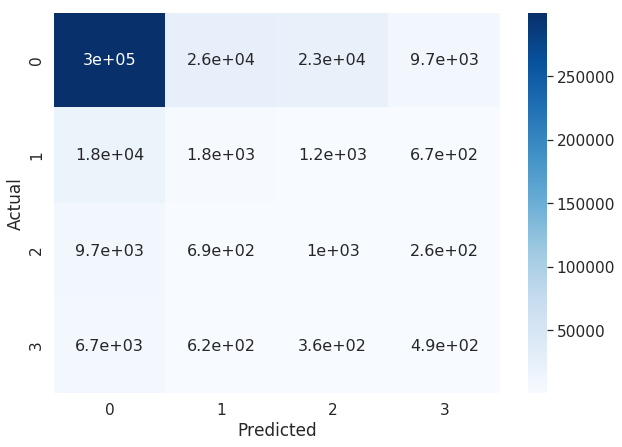

In [ ]:
matrix = confusion_matrix(y_test, max_pred, labels=[0, 1, 2, 3])
df_cm = pd.DataFrame(matrix, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})
plt.show()

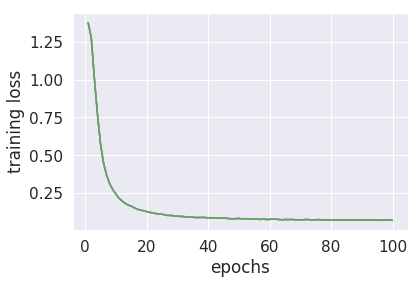

In [ ]:
sns.lineplot(x=list(range(1, epochs + 1)), y=train_loss)
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.show()

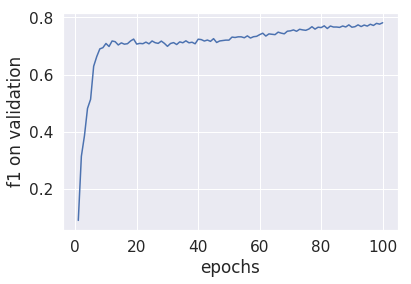

In [ ]:
sns.lineplot(x=list(range(1, epochs + 1)), y=f1)
plt.xlabel("epochs")
plt.ylabel("f1 on validation")
plt.show()

In [ ]:
print ("precision score", precision_score(y_test, max_pred,average='weighted'))
print ("recall score", recall_score(y_test, max_pred,average='weighted'))
print ("f1 score", f1_score(y_test, max_pred,average='weighted'))

precision score 0.8082953380373245
recall score 0.757281650365924
f1 score 0.7814953601248579


# DeepFM (Formal)

In [ ]:
!pip install deepctr[cpu]

In [56]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from deepctr.models import DeepFM
from deepctr.feature_column import SparseFeat, DenseFeat,get_feature_names

To utilize deepfm on the dataset, we re-process the raw data via the tools provided by deepctr package here

In [74]:
path = "/content/drive/Shareddrives/CIS 520/final project/hotel_bookings.csv"
data = pd.read_csv(path)
data['country'].fillna('others', inplace=True)
data = data.drop(['hotel', 'reservation_status'], axis=1)
for col in ['agent', 'company', 'children']: data[col].fillna(0, inplace=True)
## Numericalized by timestamp: `reservation_status_date`
col = 'reservation_status_date'
data['day_of_week'] = pd.DatetimeIndex(data[col]).dayofweek
data['day_of_year'] = pd.DatetimeIndex(data[col]).dayofyear
data.drop([col], axis=1, inplace=True)  
data

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,day_of_week,day_of_year
0,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,0.0,0.0,0,Transient,0.00,0,0,2,182
1,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,0.0,0.0,0,Transient,0.00,0,0,2,182
2,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,0.0,0.0,0,Transient,75.00,0,0,3,183
3,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,0.0,0,Transient,75.00,0,0,3,183
4,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,0.0,0,Transient,98.00,0,1,4,184
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,0,23,2017,August,35,30,2,5,2,0.0,0,BB,BEL,Offline TA/TO,TA/TO,0,0,0,A,A,0,No Deposit,394.0,0.0,0,Transient,96.14,0,0,2,249
119386,0,102,2017,August,35,31,2,5,3,0.0,0,BB,FRA,Online TA,TA/TO,0,0,0,E,E,0,No Deposit,9.0,0.0,0,Transient,225.43,0,2,3,250
119387,0,34,2017,August,35,31,2,5,2,0.0,0,BB,DEU,Online TA,TA/TO,0,0,0,D,D,0,No Deposit,9.0,0.0,0,Transient,157.71,0,4,3,250
119388,0,109,2017,August,35,31,2,5,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,89.0,0.0,0,Transient,104.40,0,0,3,250


In [ ]:
## Check NaN
print(pd.DataFrame({'#NaN': data.isnull().sum(), 
                    '%NaN': round(data.isnull().mean() * 100, 2)}))

In [76]:
sparse_features = data.loc[:, data.dtypes==np.object].columns.tolist()  
dense_features_1 = data.loc[:, data.dtypes==np.integer].columns.tolist() 
dense_features_2 = data.loc[:, data.dtypes==np.float64].columns.tolist() 
dense_features = dense_features_1 + dense_features_2
assert data.shape[1] == len(sparse_features) + len(dense_features)

In [77]:
for feat in sparse_features:
    lbe = LabelEncoder()
    data[feat] = lbe.fit_transform(data[feat])

mms = MinMaxScaler(feature_range=(0,1))
data[dense_features] = mms.fit_transform(data[dense_features])

In [78]:
sparse_feature_columns = [SparseFeat(feat, 
                                     vocabulary_size=1e6, 
                                     embedding_dim=4,
                                     use_hash=True)
                           for i,feat in enumerate(sparse_features)] 
                           #The dimension can be set according to data
dense_feature_columns = [DenseFeat(feat, 1) for feat in dense_features]

In [79]:
# varlen_feature_columns = [VarLenSparseFeat('genres', 
#                                            maxlen=max_len,
#                                            vocabulary_size=len(key2index)+1,
#                                            embedding_dim=4, 
#                                            combiner='mean',
#                                            weight_name=None)]

Generate feature columns

In [80]:
dnn_feature_columns = sparse_feature_columns + dense_feature_columns
linear_feature_columns = sparse_feature_columns + dense_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

Training set and test set

In [81]:
## Initialize X, y and split dataset
y = data['is_canceled']
X = data.drop(['is_canceled'], axis=1)
X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.20, random_state=42)
## Rebalance
X_train_balanced, y_train_balanced = SMOTE().fit_sample(X_train, y_train)

Implement DeepFM

In [93]:
linear_feature_columns

[SparseFeat(name='arrival_date_month', vocabulary_size=1000000.0, embedding_dim=4, use_hash=True, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fb4f9a09710>, embedding_name='arrival_date_month', group_name='default_group', trainable=True),
 SparseFeat(name='meal', vocabulary_size=1000000.0, embedding_dim=4, use_hash=True, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fb4f9a09748>, embedding_name='meal', group_name='default_group', trainable=True),
 SparseFeat(name='country', vocabulary_size=1000000.0, embedding_dim=4, use_hash=True, dtype='int32', embeddings_initializer=<tensorflow.python.keras.initializers.initializers_v1.RandomNormal object at 0x7fb4f9a096a0>, embedding_name='country', group_name='default_group', trainable=True),
 SparseFeat(name='market_segment', vocabulary_size=1000000.0, embedding_dim=4, use_hash=True, dtype='int32', embed

In [95]:
name = 'is_canceled' # y value

train, test = train_test_split(data, test_size=0.2)

train_model_input = {name: train[name].values for name in feature_names}
test_model_input = {name: test[name].values for name in feature_names}

In [ ]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

history = model.fit(train_model_input, train[target].values,
                    batch_size=256, epochs=10, verbose=2, validation_split=0.2, )
y_pred = model.predict(test_model_input, batch_size=256)